In [1]:
## Import packages
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.metrics import ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score
from xgboost import XGBClassifier
from matplotlib import pyplot

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# 3. DATA EXTRACTION
def extract():
    # Load the CSV files
    csv0 = pd.read_csv("ids_0.csv")
    csv1 = pd.read_csv("ids_1.csv")
    csv2 = pd.read_csv("ids_2.csv")
    # Concatenate CSV files.
    combined = pd.concat([ csv0 , csv1 , csv2], ignore_index=True)

    # Load the JSON files
    json3 = pd.read_json("ids_3.json", lines=True)
    json4 = pd.read_json("ids_4.json", lines=True)
    json7 = pd.read_json("ids_7.json", lines=True)
    json9 = pd.read_json("ids_9.json", lines=True)
    json10 = pd.read_json("ids_10.json", lines=True)
    # Concatenate JSON files.
    combined = pd.concat([combined , json3 , json4 , json7 , json9 , json10], ignore_index=True)

    # Load the Parquet files
    parquet5 = pd.read_parquet("ids_5.parquet")
    parquet6 = pd.read_parquet("ids_6.parquet")
    parquet8 = pd.read_parquet("ids_8.parquet")
    parquet11 = pd.read_parquet("ids_11.parquet")
    # Concatenate Parquet files.
    combined = pd.concat([combined , parquet5 , parquet6 , parquet8 , parquet11], ignore_index=True)
    
    # Return files as a Pandas dataframe
    return combined

# Use the created function and save the dataframe into 'data'. Contains raw data.
data = extract()

In [3]:
# 4. DATA TRANSFORMATION

# No data conversion needs to be done.
# Drop missing data. 138 rows dropped.
print(data.shape)
data = data.dropna()
print(data.shape)


(61128, 79)
(60990, 79)


In [4]:
# 5. DATA STORAGE

# Store raw data into a new CSV file called 'dataSet.csv'
data.to_csv('dataSet.csv', index=False)

In [5]:
# 6. READING DATA

# CSV file is read and stored back onto a dataframe 'data'
data = pd.read_csv('dataSet.csv')


In [6]:
# 7. EXPLORATORY ANALYSIS

# Identify shape of the dataset.
print("Shape of dataset: ",data.shape)
# Identify if datase has missing data. Data was cleared in step 4.
print("Missing data: ",data.isna().sum().sum())

Shape of dataset:  (60990, 79)
Missing data:  0


In [7]:
# Column statistics. Not standardized.
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,60990.000000,6.099000e+04,60990.000000,60990.000000,60990.000000,6.099000e+04,60990.000000,60990.000000,60990.000000,60990.000000,60990.000000,60990.000000,60990.000000,60990.000000,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,60990.000000,60990.0,60990.0,60990.0,60990.000000,60990.000000,6.099000e+04,6.099000e+04,60990.000000,60990.000000,60990.000000,60990.000000,6.099000e+04,60990.000000,60990.000000,60990.000000,60990.000000,60990.000000,60990.000000,60990.0,60990.000000,60990.000000,60990.000000,60990.000000,60990.000000,60990.000000,60990.0,60990.0,60990.0,60990.0,60990.0,60990.0,60990.000000,60990.000000,60990.000000,6.099000e+04,60990.000000,60990.000000,60990.000000,60990.000000,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04,6.099000e+04
mean,832.885030,4.190792e+07,6.123988,4.333907,384.640285,7.946146e+03,260.997950,12.463601,61.621600,101.727005,3420.969618,4.526103,1069.248091,1475.382397,inf,inf,7.938680e+06,1.086591e+07,3.826755e+07,3.917544e+06,4.066274e+07,1.151274e+07,1.377460e+07,3.808792e+07,5.289334e+06,1.472105e+07,3.475351e+06,5.950989e+06,1.298806e+07,2.549720e+05,0.019593,0.0,0.0,0.0,196.114248,139.792228,9.382231e+04,1.749192e+03,3.576488,3454.306903,480.587016,1050.048617,2.023679e+06,0.126840,0.019593,0.000016,0.360584,0.475373,0.022709,0.0,0.000016,0.287572,523.662149,61.621600,1069.248091,196.114248,0.0,0.0,0.0,0.0,0.0,0.0,6.123988,384.640285,4.333907,7.946146e+03,10608.693245,472.129333,1.418577,29.692146,4.299549e+05,3.231935e+04,4.578288e+05,4.049616e+05,3.677885e+07,1.036928e+06,3.779249e+07,3.594142e+07
std,6068.766918,4.262982e+07,36.985816,29.969723,1776.687245,1.039342e+05,303.671861,126.754898,142.807924,113.059846,3313.618896,27.701940,974.363478,1465.054822,NaN,NaN,1.635020e+07,1.422128e+07,4.242603e+07,1.591856e+07,4.350174e+07,1.947644e+07,1.825975e+07,4.257261e+07,1.932690e+07,3.118929e+07,8.950534e+06,1.456027e+07,3.027070e+07,3.445520e+06,0.138599,0.0,0.0,0.0,1167.362343,909.065202,3.287497e+05,2.552434e+04,26.191429,3288.408191,414.180320,959.685050,2.407930e+06,0.332797,0.138599,0.004049,0.480174,0.499397,0.148974,0.0,0.004049,0.523580,452.427719,142.807924,974.363478,1167.362343,0.0,0.0,0.0,0.0,0.0,0.0,36.985816,1776.687245,29.969723,1.039342e+05,13990.768673,3331.522188,8.679731,5.492623,1.588568e+06,4.261298e+05,1.700848e+06,1.558129e+06,4.270794e+07,5.517883e+06,4.279325e+07,4.300426e+07
min,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000

In [8]:
# Univariate analysis. Showing the frequency which ports appear from a sample of 30 elements.
# Modifying the number of samples can alter the graphy wildly.
# Random state is used to keep the same samples each time the code is run.
#value_counts()
sample = data[' Destination Port'].sample(30,random_state=25)
sample

33809       80
29541       80
23739       80
11410       80
7828        80
45241       80
46984       80
25665       80
55875       80
58405       80
11549       80
14181       80
22748       80
6305        80
104      51859
20680       80
26847       80
39694       80
25089       80
9860        80
48170       80
48065       80
6815        80
11579       80
15003       80
32195       80
40978       80
5875        80
34138       80
32697       80
Name:  Destination Port, dtype: int64

<Axes: xlabel='Port Number', ylabel='Frequency'>

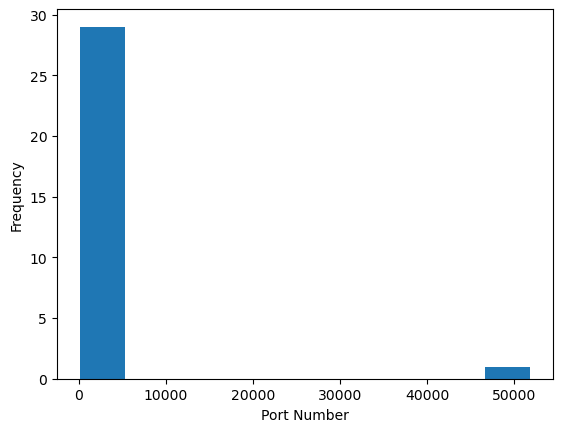

In [9]:
sample.plot(kind='hist', xlabel='Port Number')
# Mostly port 80 in this sample.

In [10]:
# 8. DATA PREPROCESSING

# Modifying feature names for easier use.
# Replacing empty spaces and dots.
print("Original: ",data.columns[2])
data.columns = data.columns.str.strip()
data.columns = data.columns.str.replace(" " , "_")
data.columns = data.columns.str.replace(".1" , "")
print("Modified: ",data.columns[2])


Original:   Total Fwd Packets
Modified:  Total_Fwd_Packets


In [11]:
print(data.shape)

# Drop duplicate values. 15,434 rows dropped.
data = data.drop_duplicates()

# Drop duplicate columns. 1 column dropped.
data = data.loc[:,~data.columns.duplicated()].copy()

# Remove the rows with a 'Heartbleed' as their 'Label'. 11 rows dropped.
data = data[data.Label != 'Heartbleed']

print(data.shape)

(60990, 79)
(45545, 78)


In [12]:
# Create 'attack' dataframe. Will become our 'y' test/train.
attack = data[['Label']]
print("Attack shape: ",attack.shape)

# Delete 'Label' from original dataset
data.drop('Label',axis=1, inplace=True)
print("Data shape: ",data.shape)

Attack shape:  (45545, 1)
Data shape:  (45545, 77)


In [13]:
print(data.shape)

# Drop features(columns) with variance less than 0.05. 17 features(columns) dropped.
# These features(columns) are less significant for our traning model.
data = data.loc[:, data.var(axis=0) >= 0.05]

print(data.shape)

(45545, 77)
(45545, 60)


In [14]:
# Encoding data.
print("Original")
print(attack.sample(5, random_state=2))

# Results will be binary. 0 = Benign connection. 1 = DoS attack.
attack['Label'] = attack['Label'].replace('BENIGN', 0, regex=True)
attack['Label'] = attack['Label'].replace('DoS Hulk', 1, regex=True)
attack['Label'] = attack['Label'].replace('DoS GoldenEye', 1, regex=True)
attack['Label'] = attack['Label'].replace('DoS Slowhttptest', 1, regex=True)

print("\nModified")
print(attack.sample(5, random_state=2))

Original
                  Label
4999             BENIGN
43099          DoS Hulk
30512          DoS Hulk
22613     DoS GoldenEye
24433  DoS Slowhttptest

Modified
       Label
4999       0
43099      1
30512      1
22613      1
24433      1


C:\Users\Luis A. Torres\AppData\Local\Temp\ipykernel_10560\1919646682.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  attack['Label'] = attack['Label'].replace('DoS Slowhttptest', 1, regex=True)


In [15]:
# 7-2. MORE EXPLORATORY ANALYSIS
# Bivariate analysis. Correlations.

# Correlation matrix. Displays how strong are the features linked.
(data
 .corr(method='pearson')
 .style
 .background_gradient(cmap='RdBu', vmin=-1, vmax=1)
)

,Destination_Port,Flow_Duration,Total_Fwd_Packets,Total_Backward_Packets,Total_Length_of_Fwd_Packets,Total_Length_of_Bwd_Packets,Fwd_Packet_Length_Max,Fwd_Packet_Length_Min,Fwd_Packet_Length_Mean,Fwd_Packet_Length_Std,Bwd_Packet_Length_Max,Bwd_Packet_Length_Min,Bwd_Packet_Length_Mean,Bwd_Packet_Length_Std,Flow_IAT_Mean,Flow_IAT_Std,Flow_IAT_Max,Flow_IAT_Min,Fwd_IAT_Total,Fwd_IAT_Mean,Fwd_IAT_Std,Fwd_IAT_Max,Fwd_IAT_Min,Bwd_IAT_Total,Bwd_IAT_Mean,Bwd_IAT_Std,Bwd_IAT_Max,Bwd_IAT_Min,Fwd_Header_Length,Bwd_Header_Length,Fwd_Packets/s,Bwd_Packets/s,Min_Packet_Length,Max_Packet_Length,Packet_Length_Mean,Packet_Length_Std,Packet_Length_Variance,FIN_Flag_Count,PSH_Flag_Count,ACK_Flag_Count,Down/Up_Ratio,Average_Packet_Size,Avg_Fwd_Segment_Size,Avg_Bwd_Segment_Size,Subflow_Fwd_Packets,Subflow_Fwd_Bytes,Subflow_Bwd_Packets,Subflow_Bwd_Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active_Mean,Active_Std,Active_Max,Active_Min,Idle_Mean,Idle_Std,Idle_Max,Idle_Min
Destination_Port,1.000000,-0.153146,-0.051344,-0.030007,0.024785,-0.035769,0.035139,-0.007643,0.080197,0.046761,-0.173409,-0.016258,-0.186906,-0.168056,-0.074342,-0.123978,-0.138511,-0.029084,-0.146264,-0.094302,-0.120336,-0.137965,-0.032962,-0.057117,-0.047843,-0.049033,-0.051668,-0.010753,-0.072050,-0.042859,0.312838,0.180205,-0.007021,-0.161235,-0.172066,-0.166307,-0.126840,-0.047838,-0.106399,0.156374,0.046085,-0.170090,0.080197,-0.186906,-0.051344,0.024785,-0.030007,-0.035769,-0.087666,0.152745,-0.011710,-0.077145,-0.043684,-0.011334,-0.043251,-0.042041,-0.131454,-0.028008,-0.135882,-0.126562
Flow_Duration,-0.153146,1.000000,0.105856,0.075180,0.047243,0.076990,0.159724,-0.121473,0.016489,0.172773,0.246739,-0.206113,0.280233,0.179267,0.385387,0.879365,0.963098,0.086835,0.998966,0.573355,0.879037,0.963265,0.132879,0.425278,0.352144,0.414398,0.431614,0.073734,0.128464,0.102065,-0.105487,-0.063918,-0.165308,0.254544,0.301692,0.244731,0.148732,0.299460,-0.429026,0.312060,-0.057594,0.287809,0.016489,0.280233,0.105856,0.047243,0.075180,0.076990,-0.429647,-0.056117,0.052954,-0.228598,0.081343,0.086783,0.095848,0.064155,0.937499,0.179167,0.962711,0.906642
Total_Fwd_Packets,-0.051344,0.105856,1.000000,0.939162,0.308773,0.930894,0.170495,-0.044605,0.036478,0.100805,0.115766,-0.072080,0.133125,0.097350,-0.072228,0.029785,0.043530,-0.075785,0.100080,-0.068932,0.042358,0.043106,-0.086423,0.071909,0.005753,-0.006415,0.012443,0.028088,0.951690,0.901340,-0.029647,-0.023581,-0.057855,0.117872,0.124782,0.105279,0.068506,-0.038908,0.108474,-0.042034,-0.069373,0.113992,0.036478,0.133125,1.000000,0.308773,0.939162,0.930894,0.089605,0.026477,0.880457,-0.005226,0.068702,0.126068,0.105504,0.045816,0.037884,0.035480,0.043837,0.033114
Total_Backward_Packets,-0.030007,0.075180,0.939162,1.000000,0.282045,0.977318,0.166082,-0.024632,0.035325,0.099885,0.107351,-0.032341,0.127132,0.081314,-0.059504,0.034798,0.047776,-0.057806,0.071837,-0.036529,0.057062,0.047299,-0.061111,0.104194,0.012518,0.033044,0.057171,-0.011682,0.892454,0.973631,-0.024685,-0.010757,-0.036430,0.108602,0.154807,0.106369,0.062266,0.032807,0.038385,-0.044280,0.071839,0.147669,0.035325,0.127132,0.939162,0.282045,1.000000,0.977318,0.021455,0.004777,0.831253,-0.075563,-0.049792,0.036490,-0.025542,-0.054508,0.052678,-0.027489,0.048028,0.055200
Total_Length_of_Fwd_Packets,0.024785,0.047243,0.308773,0.282045,1.000000,0.203938,0.391668,0.015241,0.356125,0.357789,0.030963,-0.029253,0.028392,0.022570,-0.044202,0.004416,0.003923,-0.042593,0.044340,-0.036632,0.005582,0.003755,-0.037550,0.095873,0.073263,0.037503,0.048636,0.091466,0.282393,0.253196,-0.014169,-0.006512,-0.001636,0.053247,0.073251,0.047129,0.019264,-0.015230,0.067480,-0.038293,-0.010924,0.069987,0.356125,0.028392,0.308773,1.000000,0.282045,0.203938,0.079089,0.139797,0.323654,-0.021358,0.016955,0.197905,0.065179,-0.022774,-0.000568,0.006650,0.002994,-0.001106
Total_Length_of_Bwd_Packets,-0.035769,0.076990,0.930894,0.977318,0.203938,1.000000,0

<Axes: xlabel='Flow_Duration', ylabel='Fwd_IAT_Total'>

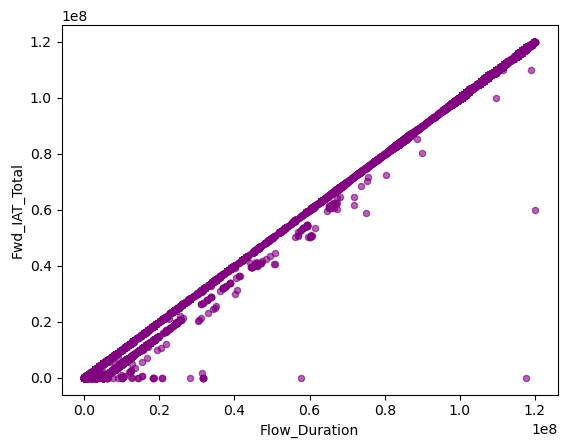

In [16]:
# Correlation visualization. High correlation. They increase similarly.
(data
 .plot.scatter(x='Flow_Duration', y='Fwd_IAT_Total', alpha=0.6, color='purple')
 )

<Axes: xlabel='Flow_Duration', ylabel='Init_Win_bytes_forward'>

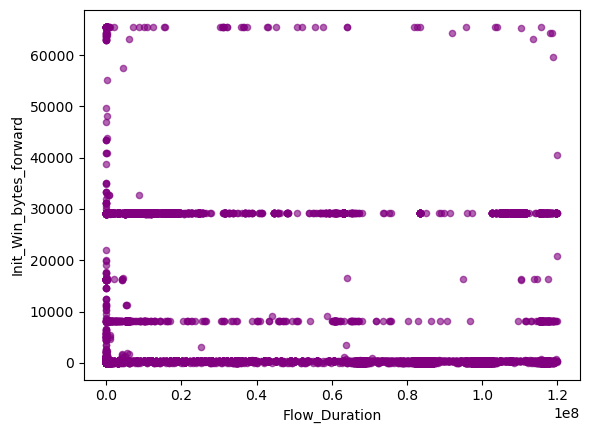

In [17]:
# Correlation visualization. Low correlation. The increase separately.
(data
 .plot.scatter(x='Flow_Duration', y='Init_Win_bytes_forward', alpha=0.6, color='purple')
 )

In [18]:
# Splitting the data.

# Convert 'data' and 'attack' to numpy arrays.
data = data.to_numpy()
attack = attack.to_numpy()

# Split the data into 4. Xtrain/yTrain and Xtest/ytest
# Split is done 75/25 respectively.
X_train, X_test, y_train, y_test = train_test_split(data, attack, test_size=0.25, random_state=6969)
# X contains our features while y contains our labels.
#stratify=attack'.

# Flatten the y sets. Causes warning if not done. Assume it affects the results.
y_train = y_train.flatten()
y_test = y_test.flatten()

In [19]:
# 9. FEATURE ENGINEERING

# Standardize the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_standard = scaler.transform(X_train)
X_test_standard = scaler.transform(X_test)
# Was 'fit' befor

In [20]:
# Describe the data to ensure correct standardization.
# Mean is closer to 0 and Standard Deviation(std) is closer to 1.
print(pd.DataFrame(X_train_standard).describe())

                 0             1             2             3             4   \
count  3.415800e+04  3.415800e+04  3.415800e+04  3.415800e+04  3.415800e+04   
mean  -3.952313e-18  4.014718e-17 -3.432272e-17 -1.102487e-17 -4.888388e-18   
std    1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00  1.000015e+00   
min   -1.550852e-01 -1.167838e+00 -5.313520e-01 -3.276095e-01 -1.942267e-01   
25%   -1.436581e-01 -9.592760e-01 -2.278738e-01 -1.872283e-01 -1.625095e-01   
50%   -1.436581e-01  2.993378e-01 -2.555491e-02  2.334343e-02 -4.004590e-02   
75%   -1.436581e-01  1.118189e+00  1.767639e-01  9.353402e-02 -1.581748e-02   
max    9.188888e+00  1.622811e+00  1.234901e+02  1.159782e+02  1.608300e+02   

                 5             6             7             8             9   \
count  3.415800e+04  3.415800e+04  3.415800e+04  3.415800e+04  3.415800e+04   
mean   5.408429e-18 -6.926949e-17  9.620763e-18  8.562999e-16  9.227820e-15   
std    1.000015e+00  1.000015e+00  1.000015e+00  1.

In [21]:
# Feature selection. XGBoost Classifier is used to select the most important features.
# The inputs are our Xtrain (60 columns) and yTrain (1 column).
xgbC = XGBClassifier()
xgbC.fit(X_train_standard,y_train)
xgbC.feature_importances_

array([9.7993731e-02, 4.8393069e-04, 1.1221851e-03, 2.4922406e-02,
       3.2868719e-04, 2.4943766e-03, 2.4952327e-03, 8.7552547e-02,
       5.7249554e-03, 8.1503373e-03, 0.0000000e+00, 1.6187661e-04,
       4.3313755e-03, 1.2343039e-02, 3.3530688e-03, 9.3072350e-04,
       1.1378137e-03, 4.3838960e-04, 4.6236007e-04, 5.4100906e-03,
       3.4444605e-04, 3.9766141e-04, 1.1692491e-03, 0.0000000e+00,
       7.8031429e-05, 0.0000000e+00, 8.4276580e-05, 4.5110625e-03,
       4.4546411e-03, 3.0175102e-04, 2.6138534e-04, 9.5109446e-03,
       6.9410700e-01, 4.8262342e-03, 4.8581205e-04, 8.7774388e-04,
       0.0000000e+00, 2.1840984e-03, 1.8597013e-04, 2.0608798e-04,
       3.8362734e-04, 1.9114717e-03, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       6.9565192e-04, 6.4589675e-03, 2.0278806e-03, 3.8779667e-04,
       0.0000000e+00, 2.4192897e-03, 0.0000000e+00, 1.2205478e-04,
       7.9453475e-04, 0.0000000e+00, 8.2215061e-04, 1.5307158e

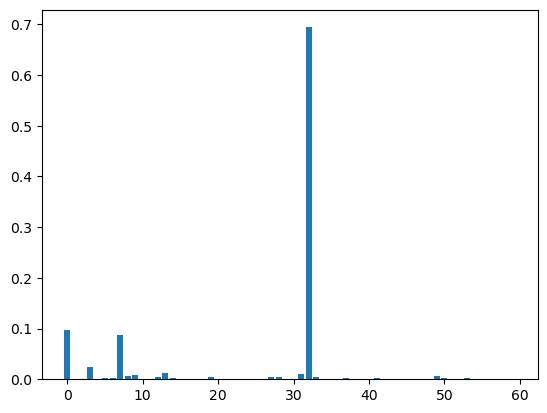

In [22]:
# Easier visualization to know which features are important and their score.
pyplot.bar(range(len(xgbC.feature_importances_)), xgbC.feature_importances_)
pyplot.show()

In [23]:
# Only the features that have an importance higher than .01 are kept.

# Use SelectFromModel to cut down the features based on the result from xgbC.
selection = SelectFromModel(xgbC, threshold=.01, prefit=True)

# This brings us from 60 features down to just 5 features.
X_train_selected = selection.transform(X_train_standard)
print("Xtrain_selected shape: ", X_train_selected.shape)

# Apply the same change to our Xtest.
X_test_selected = selection.transform(X_test_standard)
print("Xtest_selected shape: ", X_test_selected.shape)

# In goes XTrainStandard, out comes XTrainSelected. Same for test.
# The 'Select's will be that data that we use to train our models.

Xtrain_selected shape:  (34158, 5)
Xtest_selected shape:  (11387, 5)


In [24]:
# 10. PROCESSED DATA LOADING
# Save our selected Xtrain and Xtest onto their own CSV files. Same as we did in step 5, except we will not load them back this time, we will use them as they are.
pd.DataFrame(X_train_selected).to_csv('CleanTrain.csv', index=False)
pd.DataFrame(X_test_selected).to_csv('CleanTest.csv', index=False)

In [25]:
# 11. MODEL SELECTION AND TRAINING

# Before, we used XGBoostClassifier only to select the features that were important and discard the rest.
# Now, we will use XGBoostClassifier as a model to train and predict.

# XGBC MODEL (Our Best Performing Model)

# Training the model
xgbC.fit(X_train_selected , y_train)
# Make a prediction on the data we trained on.
X_train_selected_pred = xgbC.predict(X_train_selected)
# Make a prediction on the test data (Didn't train on).
X_test_selected_pred = xgbC.predict(X_test_selected)

# Scores from the first prediction. (Train data)
train_acc_perc = accuracy_score(y_train, X_train_selected_pred)
train_f1score_perc = f1_score(y_train, X_train_selected_pred)
train_precision_perc = precision_score(y_train, X_train_selected_pred)
train_recall_perc = recall_score(y_train, X_train_selected_pred)
print('Train XGBC Model')
print('Accuracy: {:.3f}'.format(train_acc_perc))
print('Precision: {:.3f}'.format(train_precision_perc))
print('Recall: {:.3f}'.format(train_recall_perc))
print('F1-score: {:.3f}'.format(train_f1score_perc))

# Scores from the second prediction. (Test data)
test_acc_perc = accuracy_score(y_test, X_test_selected_pred)
test_f1score_perc = f1_score(y_test, X_test_selected_pred)
test_precision_perc = precision_score(y_test, X_test_selected_pred)
test_recall_perc = recall_score(y_test, X_test_selected_pred)
print('\nTest XGBC Model')
print('Accuracy: {:.3f}'.format(test_acc_perc))
print('Precision: {:.3f}'.format(test_precision_perc))
print('Recall: {:.3f}'.format(test_recall_perc))
print('F1-score: {:.3f}'.format(test_f1score_perc))

# Score calculation methods are imported from sklearn.metrics

Train XGBC Model
Accuracy: 0.995
Precision: 0.995
Recall: 0.999
F1-score: 0.997

Test XGBC Model
Accuracy: 0.995
Precision: 0.995
Recall: 0.999
F1-score: 0.997


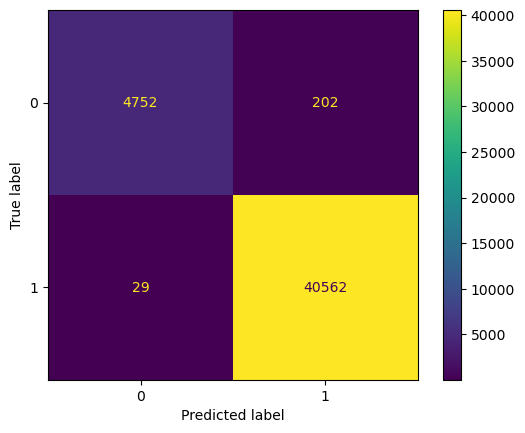

In [26]:
# Confusion matrix allows us to view the results from our prediction easily.
#  [Actual No / Predicted No]   [Actual No / Predicted Yes]       Or    [Correct prediction]  [Incorrect prediction]
#  [Actual Yes / Predicted No]  [Actual Yes / Predicted Yes]           [Incorrect prediction]  [Correct predicion]

# If you add up the numbers we end up with Xtrain + Xtest (The whole dataset before splitting).
ConfusionMatrixDisplay.from_estimator(xgbC, np.concatenate((X_train_selected, X_test_selected), axis=0), np.concatenate((y_train, y_test)))

In [27]:
#PERCEPTRON MODEL

# Training the model
perceptron = Perceptron(eta0=0.001, random_state=1)
perceptron.fit(X_train_selected,y_train)

# Make a prediction on the data we trained on.
X_train_selected_pred = perceptron.predict(X_train_selected)
# Make a prediction on the test data (Didn't train on).
X_test_selected_pred = perceptron.predict(X_test_selected)

# Scores from the first prediction. (Train data)
train_acc_perc = accuracy_score(y_train, X_train_selected_pred)
train_f1score_perc = f1_score(y_train, X_train_selected_pred)
train_precision_perc = precision_score(y_train, X_train_selected_pred)
train_recall_perc = recall_score(y_train, X_train_selected_pred)
print('Train Perceptron Model')
print('Accuracy: {:.3f}'.format(train_acc_perc))
print('Precision: {:.3f}'.format(train_precision_perc))
print('Recall: {:.3f}'.format(train_recall_perc))
print('F1-score: {:.3f}'.format(train_f1score_perc))

# Scores from the second prediction. (Train data)
test_acc_perc = accuracy_score(y_test, X_test_selected_pred)
test_f1score_perc = f1_score(y_test, X_test_selected_pred)
test_precision_perc = precision_score(y_test, X_test_selected_pred)
test_recall_perc = recall_score(y_test, X_test_selected_pred)
print('\nTest Perceptron Model')
print('Accuracy: {:.3f}'.format(test_acc_perc))
print('Precision: {:.3f}'.format(test_precision_perc))
print('Recall: {:.3f}'.format(test_recall_perc))
print('F1-score: {:.3f}'.format(test_f1score_perc))

Train Perceptron Model
Accuracy: 0.982
Precision: 0.988
Recall: 0.992
F1-score: 0.990

Test Perceptron Model
Accuracy: 0.981
Precision: 0.987
Recall: 0.992
F1-score: 0.990


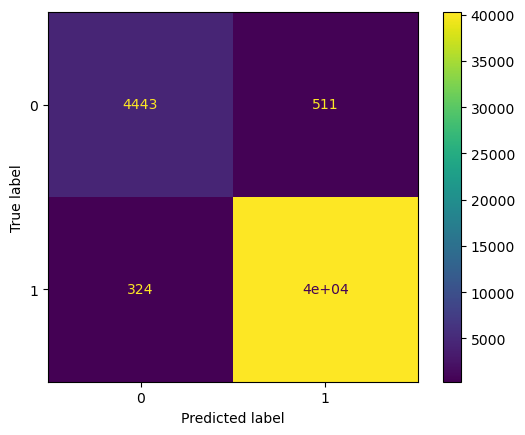

In [28]:
# Confusion matrix allows us to view the results from our prediction easily.
#  [Actual No / Predicted No]   [Actual No / Predicted Yes]       Or    [Correct prediction]  [Incorrect prediction]
#  [Actual Yes / Predicted No]  [Actual Yes / Predicted Yes]           [Incorrect prediction]  [Correct predicion]

# If you add up the numbers we end up with Xtrain + Xtest (The whole dataset before splitting).
ConfusionMatrixDisplay.from_estimator(perceptron, np.concatenate((X_train_selected, X_test_selected), axis=0), np.concatenate((y_train, y_test)))

In [29]:
#ADABOOST MODEL

# Training the model. Perceptron model must be done before since this model uses it.
adaboost_perc = AdaBoostClassifier(estimator=Perceptron(eta0=0.001, random_state=1), n_estimators=100, learning_rate=0.001, random_state=1, algorithm='SAMME')
adaboost_perc.fit(X_train_selected,y_train)

# Make a prediction on the data we trained on.
X_train_selected_pred = adaboost_perc.predict(X_train_selected)
# Make a prediction on the test data (Didn't train on).
X_test_selected_pred = adaboost_perc.predict(X_test_selected)

# Scores from the first prediction. (Train data)
train_acc_perc = accuracy_score(y_train, X_train_selected_pred)
train_f1score_perc = f1_score(y_train, X_train_selected_pred)
train_precision_perc = precision_score(y_train, X_train_selected_pred)
train_recall_perc = recall_score(y_train, X_train_selected_pred)
print('Train ADABoost Model')
print('Accuracy: {:.3f}'.format(train_acc_perc))
print('Precision: {:.3f}'.format(train_precision_perc))
print('Recall: {:.3f}'.format(train_recall_perc))
print('F1-score: {:.3f}'.format(train_f1score_perc))

# Scores from the second prediction. (Train data)
test_acc_perc = accuracy_score(y_test, X_test_selected_pred)
test_f1score_perc = f1_score(y_test, X_test_selected_pred)
test_precision_perc = precision_score(y_test, X_test_selected_pred)
test_recall_perc = recall_score(y_test, X_test_selected_pred)
print('\nTest ADABoost Model')
print('Accuracy: {:.3f}'.format(test_acc_perc))
print('Precision: {:.3f}'.format(test_precision_perc))
print('Recall: {:.3f}'.format(test_recall_perc))
print('F1-score: {:.3f}'.format(test_f1score_perc))

Train ADABoost Model
Accuracy: 0.980
Precision: 0.985
Recall: 0.992
F1-score: 0.989

Test ADABoost Model
Accuracy: 0.980
Precision: 0.986
Recall: 0.992
F1-score: 0.989


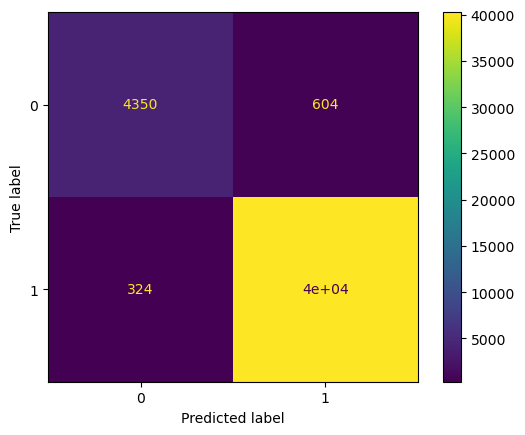

In [30]:
# Confusion matrix allows us to view the results from our prediction easily.
#  [Actual No / Predicted No]   [Actual No / Predicted Yes]       Or    [Correct prediction]  [Incorrect prediction]
#  [Actual Yes / Predicted No]  [Actual Yes / Predicted Yes]           [Incorrect prediction]  [Correct predicion]

# If you add up the numbers we end up with Xtrain + Xtest (The whole dataset before splitting).
ConfusionMatrixDisplay.from_estimator(adaboost_perc, np.concatenate((X_train_selected, X_test_selected), axis=0), np.concatenate((y_train, y_test)))

In [31]:
#LOGISTIC REGRESSION MODEL

# Training the model
lr = LogisticRegression()
lr.fit(X_train_selected,y_train)
# Make a prediction on the data we trained on.
X_train_selected_pred = lr.predict(X_train_selected)
# Make a prediction on the test data (Didn't train on).
X_test_selected_pred = lr.predict(X_test_selected)

# Scores from the first prediction. (Train data)
train_acc_perc = accuracy_score(y_train, X_train_selected_pred)
train_f1score_perc = f1_score(y_train, X_train_selected_pred)
train_precision_perc = precision_score(y_train, X_train_selected_pred)
train_recall_perc = recall_score(y_train, X_train_selected_pred)
print('Train Logistic Regression Model')
print('Accuracy: {:.3f}'.format(train_acc_perc))
print('Precision: {:.3f}'.format(train_precision_perc))
print('Recall: {:.3f}'.format(train_recall_perc))
print('F1-score: {:.3f}'.format(train_f1score_perc))

# Scores from the second prediction. (Train data)
test_acc_perc = accuracy_score(y_test, X_test_selected_pred)
test_f1score_perc = f1_score(y_test, X_test_selected_pred)
test_precision_perc = precision_score(y_test, X_test_selected_pred)
test_recall_perc = recall_score(y_test, X_test_selected_pred)
print('\nTest Logistic Regression Model')
print('Accuracy: {:.3f}'.format(test_acc_perc))
print('Precision: {:.3f}'.format(test_precision_perc))
print('Recall: {:.3f}'.format(test_recall_perc))
print('F1-score: {:.3f}'.format(test_f1score_perc))


Train Logistic Regression Model
Accuracy: 0.904
Precision: 0.929
Recall: 0.966
F1-score: 0.947

Test Logistic Regression Model
Accuracy: 0.904
Precision: 0.927
Recall: 0.969
F1-score: 0.948


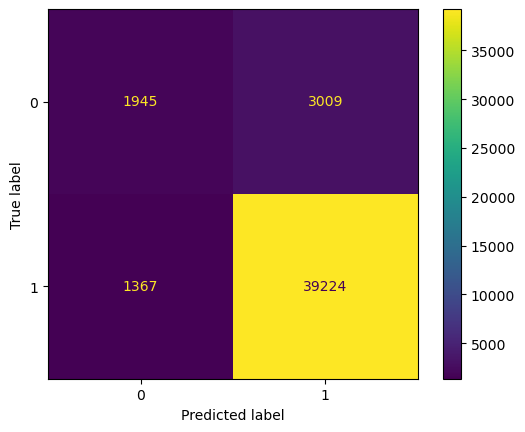

In [32]:
# Confusion matrix allows us to view the results from our prediction easily.
#  [Actual No / Predicted No]   [Actual No / Predicted Yes]       Or    [Correct prediction]  [Incorrect prediction]
#  [Actual Yes / Predicted No]  [Actual Yes / Predicted Yes]           [Incorrect prediction]  [Correct predicion]

# If you add up the numbers we end up with Xtrain + Xtest (The whole dataset before splitting).
ConfusionMatrixDisplay.from_estimator(lr, np.concatenate((X_train_selected, X_test_selected), axis=0), np.concatenate((y_train, y_test)))

In [33]:
#MAJORITYVOTING MODEL

# Training the model. Perceptron, AdaBoost, and LogisticRegression must be done before, since this model uses them.
hard_majorityvote = VotingClassifier(estimators=[('perceptron', perceptron),('adaboost_perc', adaboost_perc),('logistic regression', lr)],voting='hard')
hard_majorityvote.fit(X_train_selected,y_train)

# Make a prediction on the data we trained on.
X_train_selected_pred = hard_majorityvote.predict(X_train_selected)
# Make a prediction on the test data (Didn't train on).
X_test_selected_pred = hard_majorityvote.predict(X_test_selected)

# Scores from the first prediction. (Train data)
train_acc_perc = accuracy_score(y_train, X_train_selected_pred)
train_f1score_perc = f1_score(y_train, X_train_selected_pred)
train_precision_perc = precision_score(y_train, X_train_selected_pred)
train_recall_perc = recall_score(y_train, X_train_selected_pred)
print('Train Mayority Voting Model')
print('Accuracy: {:.3f}'.format(train_acc_perc))
print('Precision: {:.3f}'.format(train_precision_perc))
print('Recall: {:.3f}'.format(train_recall_perc))
print('F1-score: {:.3f}'.format(train_f1score_perc))

# Scores from the second prediction. (Train data)
test_acc_perc = accuracy_score(y_test, X_test_selected_pred)
test_f1score_perc = f1_score(y_test, X_test_selected_pred)
test_precision_perc = precision_score(y_test, X_test_selected_pred)
test_recall_perc = recall_score(y_test, X_test_selected_pred)
print('\nTest Mayority Voting Model')
print('Accuracy: {:.3f}'.format(test_acc_perc))
print('Precision: {:.3f}'.format(test_precision_perc))
print('Recall: {:.3f}'.format(test_recall_perc))
print('F1-score: {:.3f}'.format(test_f1score_perc))

Train Mayority Voting Model
Accuracy: 0.980
Precision: 0.985
Recall: 0.992
F1-score: 0.989

Test Mayority Voting Model
Accuracy: 0.980
Precision: 0.986
Recall: 0.992
F1-score: 0.989


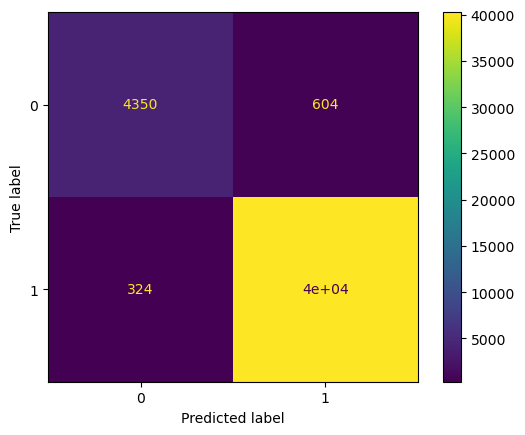

In [34]:
# Confusion matrix allows us to view the results from our prediction easily.
#  [Actual No / Predicted No]   [Actual No / Predicted Yes]       Or    [Correct prediction]  [Incorrect prediction]
#  [Actual Yes / Predicted No]  [Actual Yes / Predicted Yes]           [Incorrect prediction]  [Correct predicion]

# If you add up the numbers we end up with Xtrain + Xtest (The whole dataset before splitting).
ConfusionMatrixDisplay.from_estimator(hard_majorityvote, np.concatenate((X_train_selected, X_test_selected), axis=0), np.concatenate((y_train, y_test)))